# Penguins
The following notebook is designed as an example in forming a data science workflow. We use a toy example involving a classification task based on a few numerical and categorical columns.

> **Objective:** Create a model to identify the Species & Island a Penguin is from based on its body specifications
> **Methodology:**
> 1) Clean Data
> 2) Impute Missing Values
> 3) Scale & Balance Training Data
> 4) Generate Models with Optimized Hyper-parameters
> 5) Finalize Best Model
> 6) Interpret Results

In [68]:
import joblib
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import optuna

In [69]:
# Globals
overwrite=False
random_state=42

In [71]:
dataframe = pd.read_csv('data/penguins_size.csv')
dataframe['species-island'] = dataframe['species'] + ' ' + dataframe['island']  # concatenating species & island
dataframe = dataframe.drop(['species', 'island'], axis=1)  # dropping original species & island columns
dataframe.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species-island
0,39.1,18.7,181.0,3750.0,MALE,Adelie Torgersen
1,39.5,17.4,186.0,3800.0,FEMALE,Adelie Torgersen
2,40.3,18.0,195.0,3250.0,FEMALE,Adelie Torgersen
3,NaN,NaN,NaN,NaN,NaN,Adelie Torgersen
4,36.7,19.3,193.0,3450.0,FEMALE,Adelie Torgersen


## Summary Views of Dataframe

In [72]:
print(f'Count of Columns in Dataframe:      {len(dataframe.columns.tolist())}')
print(f'Count of Rows in Dataframe:         {len(dataframe)}')

Count of Columns in Dataframe:      6
Count of Rows in Dataframe:         344


In [73]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                334 non-null    object 
 5   species-island     344 non-null    object 
dtypes: float64(4), object(2)
memory usage: 16.2+ KB


In [74]:
dataframe.isnull().sum()

culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
species-island        0
dtype: int64

In [75]:
dataframe.groupby('species-island').count()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
species-island,,,,,
Adelie Biscoe,44,44,44,44,44
Adelie Dream,56,56,56,56,55
Adelie Torgersen,51,51,51,51,47
Chinstrap Dream,68,68,68,68,68
Gentoo Biscoe,123,123,123,123,120


> Notes:
> Based on the following summary tables we find:
> 1) There are a few null values to deal with
> 2) The proportion of target values is imbalanced

## Removing Errors in Dataset

In [76]:
dataframe.sex.unique()

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

In [77]:
dataframe[dataframe.sex == '.']

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species-island
336,44.5,15.7,217.0,4875.0,.,Gentoo Biscoe


In [78]:
dataframe.at[336, 'sex'] = np.nan  # converting to nan to apply solution alongside other null values
dataframe.loc[336]

culmen_length_mm              44.5
culmen_depth_mm               15.7
flipper_length_mm            217.0
body_mass_g                 4875.0
sex                            NaN
species-island       Gentoo Biscoe
Name: 336, dtype: object

## Null Values

In [79]:
nulls = pd.DataFrame()
for col in dataframe.columns.tolist():
    ndf = pd.DataFrame(dataframe[dataframe[col].isnull()])
    for idx in ndf.index.tolist():
        if idx in nulls.index.tolist():
            ndf = ndf.drop(index=idx)
    nulls = pd.concat([nulls, ndf])

nulls

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species-island
3,NaN,NaN,NaN,NaN,NaN,Adelie Torgersen
339,NaN,NaN,NaN,NaN,NaN,Gentoo Biscoe
8,34.1,18.1,193.0,3475.0,NaN,Adelie Torgersen
9,42.0,20.2,190.0,4250.0,NaN,Adelie Torgersen
10,37.8,17.1,186.0,3300.0,NaN,Adelie Torgersen
11,37.8,17.3,180.0,3700.0,NaN,Adelie Torgersen
47,37.5,18.9,179.0,2975.0,NaN,Adelie Dream
246,44.5,14.3,216.0,4100.0,NaN,Gentoo Biscoe
286,46.2,14.4,214.0,4650.0,NaN,Gentoo Biscoe
324,47.3,13.8,216.0,4725.0,NaN,Gentoo Biscoe


> Note:
We are missing numerical data from two specific labels
> * Adelie Torgersen
> * Gentoo Biscoe

>To deal with the null values we are going to investigate the distribution of values within each respective species-island label to fill in the missing values with our best estimates of where these values would typically fall

## Adelie Torgersen

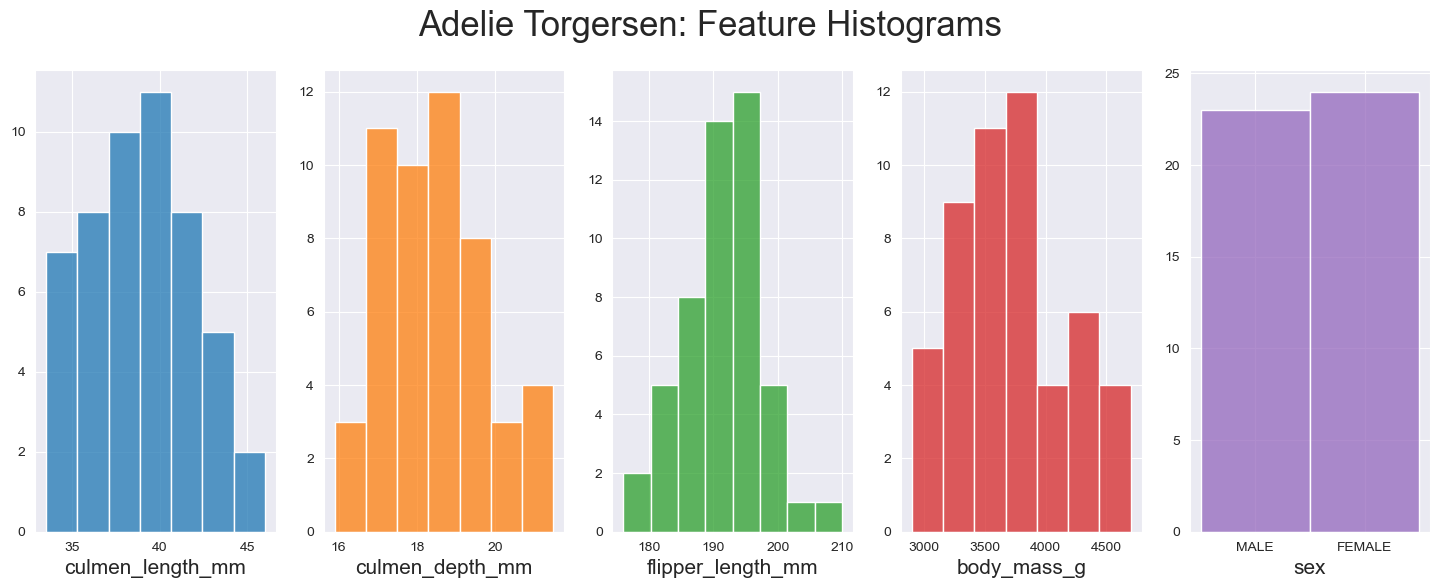

In [80]:
label = 'Adelie Torgersen'
df = dataframe[dataframe['species-island']==label]
nrows = 1
ncols = 5
figsize = (18, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize,)
fig.suptitle(f'{label}: Feature Histograms', fontsize=25)
for n, col in enumerate(df.columns.tolist()[:ncols]):
    p = sns.histplot(df, x=col, color=sns.color_palette()[n], ax=axes[n])
    p.set_xlabel(col, fontsize=15)
    p.set_ylabel('')

In [81]:
# Impute Median Value over Missing Numerical Values
ncols = 4  # first four columns are float dtypes
index = 3
for n, col in enumerate(df.columns.tolist()[:ncols]):
    dataframe.at[index, col] = df[col].median()  # implementing Median per Statistics Standards
# dataframe.at[index, 'sex'] = df['sex'].mode()[0]  # implementing Mode for Categorical Feature

In [82]:
dataframe.loc[3]

culmen_length_mm                 38.9
culmen_depth_mm                  18.4
flipper_length_mm               191.0
body_mass_g                    3700.0
sex                               NaN
species-island       Adelie Torgersen
Name: 3, dtype: object

## Gentoo Biscoe

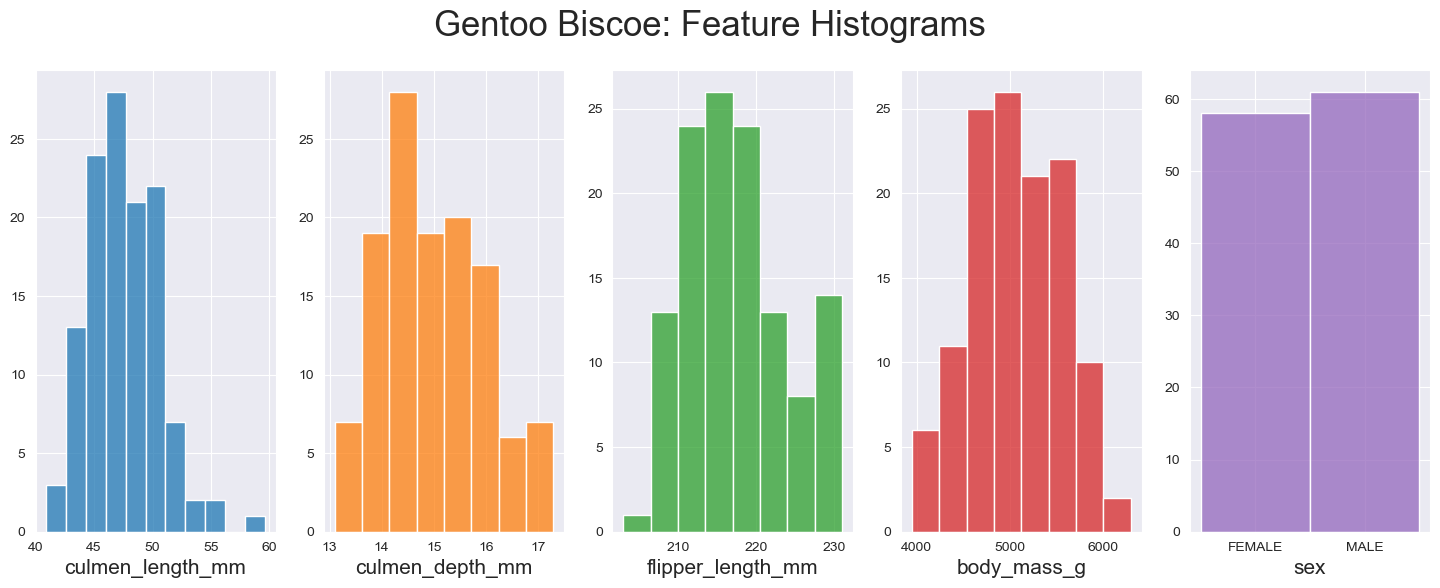

In [83]:
label = 'Gentoo Biscoe'
df = dataframe[dataframe['species-island']==label]
nrows = 1
ncols = 5
figsize = (18, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize,)
fig.suptitle(f'{label}: Feature Histograms', fontsize=25)
for n, col in enumerate(df.columns.tolist()[:ncols]):
    p = sns.histplot(df, x=col, color=sns.color_palette()[n], ax=axes[n])
    p.set_xlabel(col, fontsize=15)
    p.set_ylabel('')

In [84]:
# Impute Median Value over Missing Numerical Values
ncols = 4  # first four columns are float dtypes
index = 339
for n, col in enumerate(df.columns.tolist()[:ncols]):
    dataframe.at[index, col] = df[col].median()  # implementing Median per Statistics Standards
# dataframe.at[index, 'sex'] = df['sex'].mode()[0]  # implementing Mode for Categorical Feature

In [85]:
dataframe.loc[339]

culmen_length_mm              47.3
culmen_depth_mm               15.0
flipper_length_mm            216.0
body_mass_g                 5000.0
sex                            NaN
species-island       Gentoo Biscoe
Name: 339, dtype: object

# ML Imputation Method
> Since the values within the remaining rows of null values relate to the categorical variable of sex specifically, we will use the numerical values and there relative distances within the sex feature to determine sex for the null values.

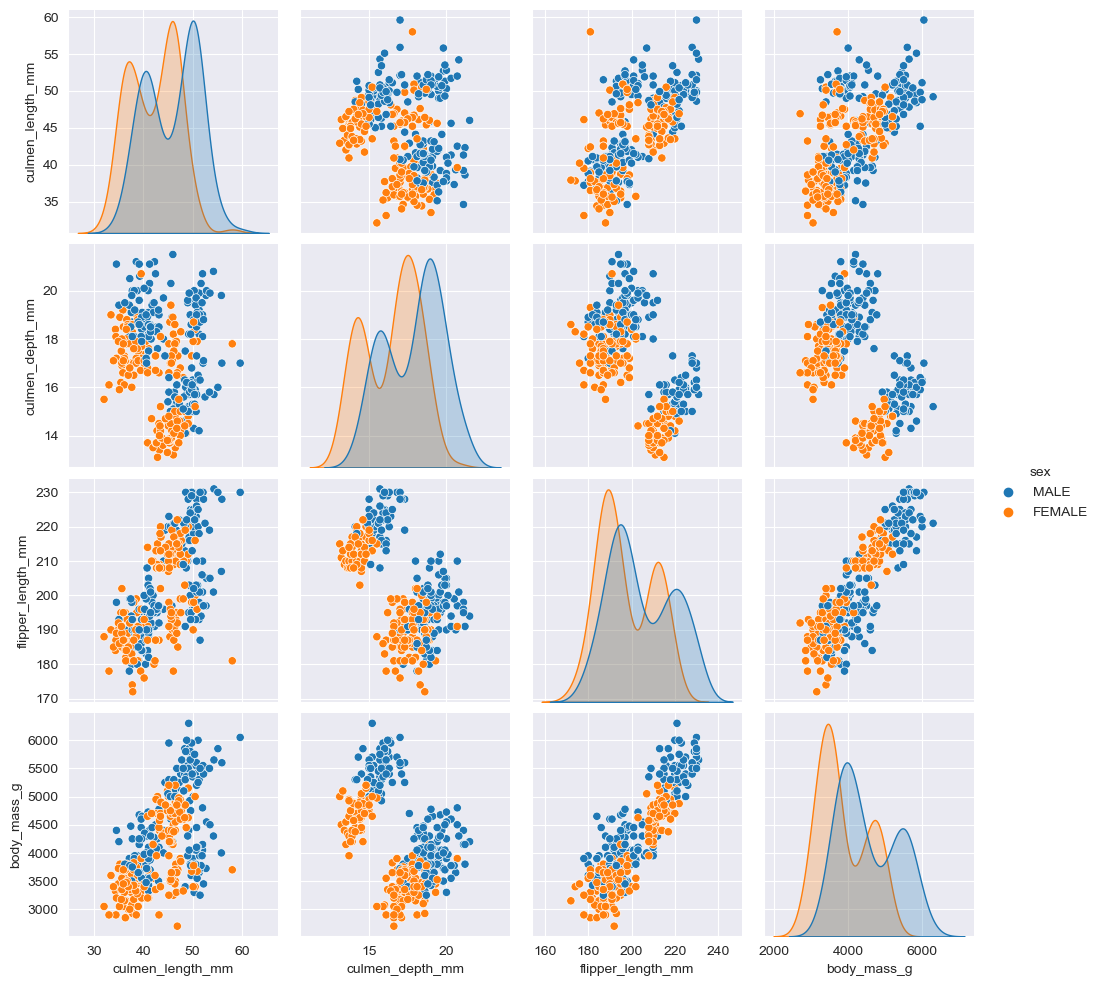

In [86]:
sns.pairplot(dataframe, hue='sex')

In [87]:
penguins3D = px.scatter_3d(
    data_frame=dataframe,
    x='culmen_length_mm',
    y='culmen_depth_mm',
    z='flipper_length_mm',
    title='Penguin Features',
    color='sex',
    color_discrete_map={
        'MALE':'royalblue',
        'FEMALE':'darkorange',
    },
)

penguins3D.update_traces(
    marker=dict(
        line=dict(
            color='#000000',
            width=1,
        )
    ),
)

penguins3D.update_layout(
    title_x=0.5,
)

penguins3D.show()

# Scaling & Dividing Data

In [88]:
scaler = StandardScaler()
X_num = dataframe.columns.tolist()[:4]  # compiling numerical features for normalizing

dev = dataframe[~dataframe.sex.isnull()]
test = dataframe[dataframe.sex.isnull()]

training, validation = train_test_split(dev, test_size=0.25, random_state=random_state)

# Fitting Scaler
norm_cols = scaler.fit_transform(training[X_num])
training[X_num] = norm_cols

norm_cols = scaler.transform(validation[X_num])
validation[X_num] = norm_cols

norm_cols = scaler.transform(test[X_num])
test[X_num] = norm_cols

# Separating X & y
X_train = training[X_num]
y_train = training['sex']

X_valid = validation[X_num]
y_valid = validation['sex']

X_test = test[X_num]
y_test = test['sex']

/var/folders/jf/l5ml53p101qcwddgjp8yrzw00000gn/T/ipykernel_30938/1329815577.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
def hp_space(trial: optuna.Trial):
    return dict(
        n_estimators=trial.suggest_int('n_estimators', low=50,high=200, step=10),
        min_samples_split=trial.suggest_int('min_samples_split', low=2, high=5),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', low=1, high=5),
        random_state=random_state,
    )

def objective(trial: optuna.Trial):
    randforest = RandomForestClassifier(**hp_space(trial))
    randforest.fit(X_train, y_train)
    accuracy = randforest.score(X_valid, y_valid)
    return accuracy

study = optuna.create_study(
    study_name='imputation',
    direction='maximize',
)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(
    func=objective,
    n_trials=20,
    gc_after_trial=True,
    show_progress_bar=True,
)

/Users/adriangallard/opt/anaconda3/envs/Any/lib/python3.9/site-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/20 [00:00<?, ?it/s]

In [90]:
study.best_params

{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 1}

In [91]:
optuna.visualization.plot_contour(study)

In [92]:
# Fit Model using best parameters from Study
randforest = RandomForestClassifier(**study.best_params)
X = dev[X_num]
y = dev['sex']
randforest.fit(X, y)

# Use Model to Interpret Missing Values based on other columns
predictions = randforest.predict(test[X_num])
test.sex = predictions

/var/folders/jf/l5ml53p101qcwddgjp8yrzw00000gn/T/ipykernel_30938/3016499096.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Imputation Results

In [93]:
dataframe = pd.concat([dev, test])
dataframe.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species-island
0,39.1,18.7,181.0,3750.0,MALE,Adelie Torgersen
1,39.5,17.4,186.0,3800.0,FEMALE,Adelie Torgersen
2,40.3,18.0,195.0,3250.0,FEMALE,Adelie Torgersen
4,36.7,19.3,193.0,3450.0,FEMALE,Adelie Torgersen
5,39.3,20.6,190.0,3650.0,MALE,Adelie Torgersen


In [94]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 0 to 339
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   344 non-null    float64
 1   culmen_depth_mm    344 non-null    float64
 2   flipper_length_mm  344 non-null    float64
 3   body_mass_g        344 non-null    float64
 4   sex                344 non-null    object 
 5   species-island     344 non-null    object 
dtypes: float64(4), object(2)
memory usage: 18.8+ KB


# Generating Updated Training, Validation, & Test Sets

In [95]:
lb = LabelBinarizer()
sex_enc = lb.fit_transform(dataframe.sex)
dataframe.sex = sex_enc
dataframe.sex.head()

0    1
1    0
2    0
4    0
5    1
Name: sex, dtype: int64

In [96]:
dev, test = train_test_split(dataframe, test_size=0.1, random_state=random_state)
training, validation = train_test_split(dev, test_size=0.2, random_state=random_state)

X_num = dataframe.columns.tolist()[:4]  # continuous numerical features
X_cols = dataframe.columns.tolist()[:5]  # includes categorical features

norm_cols = scaler.fit_transform(training[X_num])
training[X_num] = norm_cols

norm_cols = scaler.transform(validation[X_num])
validation[X_num] = norm_cols

norm_cols = scaler.transform(test[X_num])
test[X_num] = norm_cols

# Balancing Training Data

In [97]:
training['species-island'].value_counts()

Gentoo Biscoe       83
Chinstrap Dream     50
Adelie Dream        45
Adelie Torgersen    36
Adelie Biscoe       33
Name: species-island, dtype: int64

In [98]:
major_class = training['species-island'].value_counts().index.tolist()[0]
n_samples = max(training['species-island'].value_counts().tolist())
upsample_classes = training['species-island'].value_counts().index.tolist()[1:]
base = training[training['species-island'] == major_class]
for up in upsample_classes:
    sample = training[training['species-island'] == up]
    upsample = resample(
        sample,
        replace=True,
        n_samples=n_samples,
        random_state=random_state,
    )
    base = pd.concat([base, upsample])
training = base.sample(frac=1).reset_index(drop=True)  # reshuffle dataframe & remove original indices

In [99]:
training['species-island'].value_counts()

Adelie Biscoe       83
Adelie Dream        83
Chinstrap Dream     83
Adelie Torgersen    83
Gentoo Biscoe       83
Name: species-island, dtype: int64

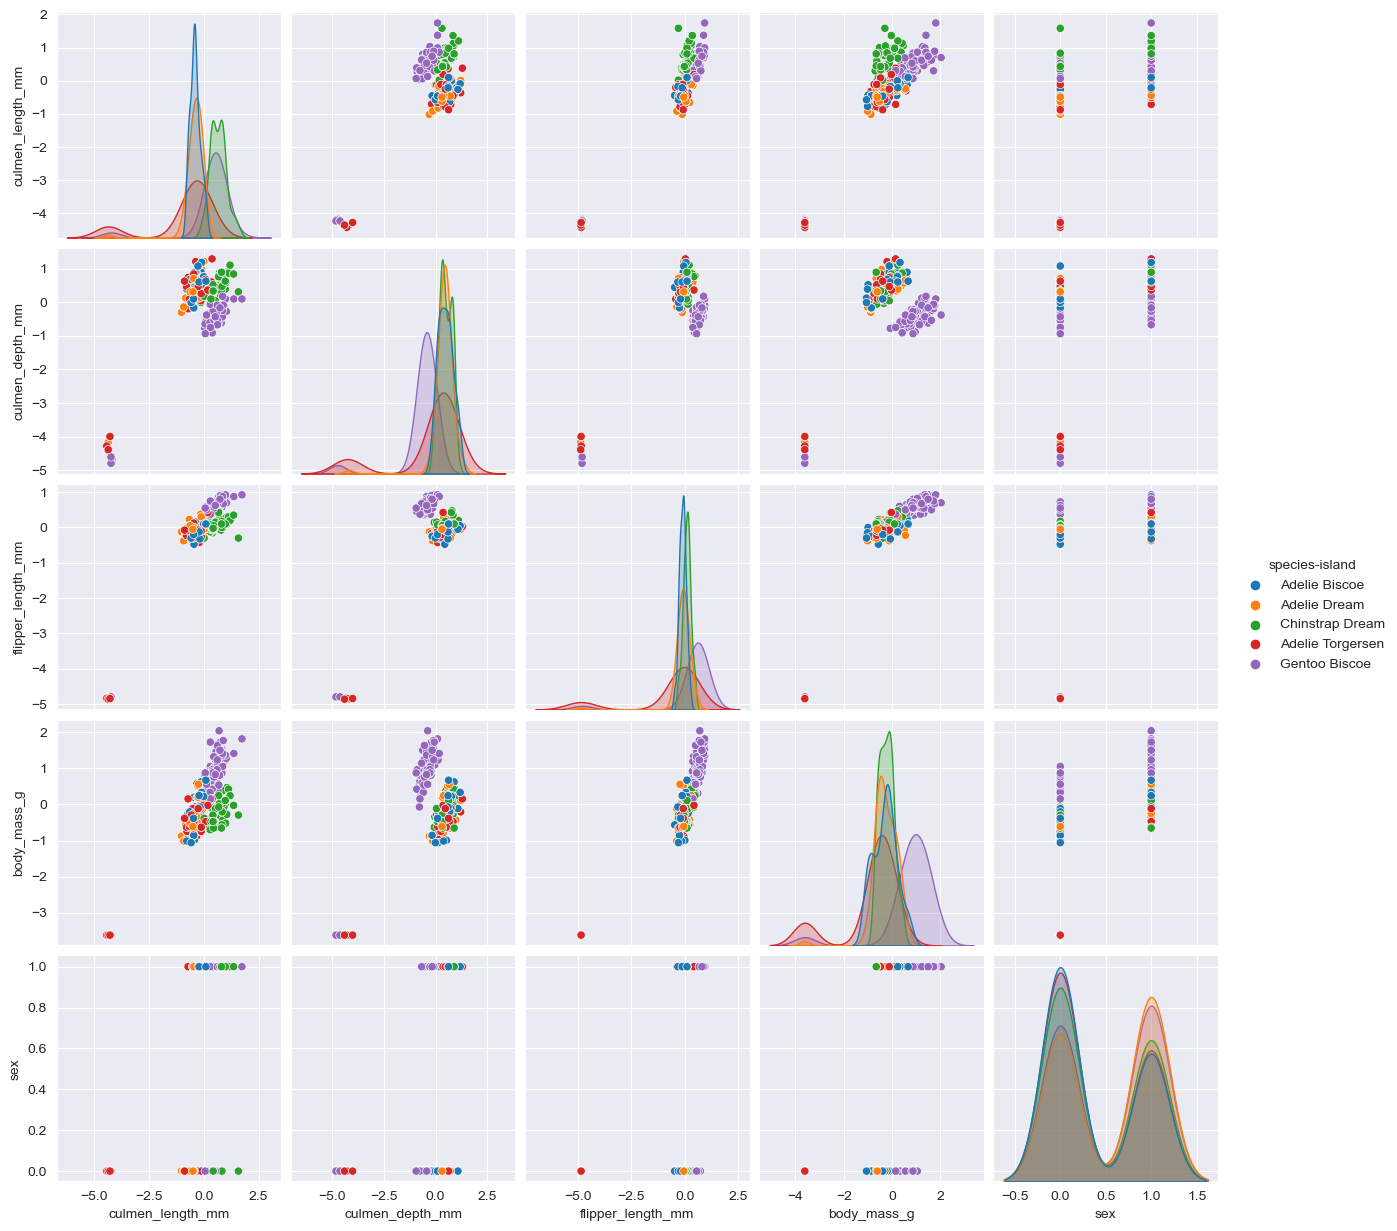

In [100]:
sns.pairplot(data=training, hue='species-island', palette='tab10')

In [101]:
# splitting datasets into X & y values
X_train, y_train = training.drop('species-island', axis=1), training['species-island']
X_valid, y_valid = validation[X_cols], validation['species-island']
X_test, y_test = test[X_cols], test['species-island']

# Investigating Outliers

In [102]:
pca = PCA(n_components=2, random_state=random_state)
pca_data = pca.fit_transform(X=X_train,)
pca_X = pca_data[:,0]
pca_Y = pca_data[:,1]

px.scatter(
    data_frame=training,
    x=pca_X,
    y=pca_Y,
    color='species-island',
    title='PCA | Species-Island',
    color_discrete_sequence=px.colors.qualitative.T10,
)

In [103]:
X_num = dataframe.columns.tolist()[:4]
px.box(
    data_frame=training[X_num],
    color='variable',  # use 'variable' when color applies to X-axis values specifically
    color_discrete_map={X_num[i]:x for i, x in enumerate(px.colors.qualitative.G10[:4])},
)

In [104]:
class outlier_detection:
    def __init__(self):
        """
        Class containing multiple outlier detection methods for simple integration.
        Receives pandas Data Frame with appropriate Columns as List.
        Expects column values to be continuous numerical values.
        Appends new column to original dataframe identifying outliers based on method chosen.
        """

        from sklearn.cluster import DBSCAN
        from sklearn.ensemble import IsolationForest
        from sklearn.neighbors import LocalOutlierFactor

        self.dbscan_ = DBSCAN
        self.isoforest_ = IsolationForest
        self.lof_ = LocalOutlierFactor

        self.db_ = "Run dbscan method and fit to dataframe..."

    @staticmethod
    def std_dev(df:pd.DataFrame, columns):

        for column in columns:
            std = np.std(df[column])
            mean = np.mean(df[column])
            cut_off = std * 3

            lower_limit = mean - cut_off
            upper_limit = mean + cut_off

            outlier_column = 'outlier_std_dev'
            df[outlier_column] = np.NaN
            for idx in df.index.tolist():
                if df[column][idx] > upper_limit:
                    df.at[idx, outlier_column] = True
                elif df[column][idx] < lower_limit:
                    df.at[idx, outlier_column] = True
        df.outlier_std_dev = df.outlier_std_dev.fillna(value=False)

    @staticmethod
    def iqr(df:pd.DataFrame, columns):
        for column in columns:
            q1, q3 = np.percentile(df[column], [25,75])
            iqr = q3 - q1
            lower_fence = q1 - (1.5 * iqr)
            upper_fence = q3 + (1.5 * iqr)

            outlier_column = 'outlier_iqr'
            df[outlier_column] = np.NaN
            for idx in df.index.tolist():
                if df[column][idx] > upper_fence:
                    df.at[idx, outlier_column] = True
                elif df[column][idx] < lower_fence:
                    df.at[idx, outlier_column] = True
        df.outlier_iqr = df.outlier_iqr.fillna(value=False)

    def dbscan(self, df:pd.DataFrame, columns, visual=True,):

        from sklearn.neighbors import NearestNeighbors
        from kneed import KneeLocator

        neighbor = NearestNeighbors(n_neighbors=2) # eps considers two points when calculating if they are neighbors
        nbrs = neighbor.fit(df[columns]) # fitting NearestNeighbors to Data
        distances, indices = nbrs.kneighbors(df[columns]) # retrieving distances and indices from NearestNeighbors

        distances = np.sort(distances,axis=0)
        distances = distances[:,1]

        kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
        index = kneedle.elbow
        epsilon = distances[index]

        n = len(df)
        min_samples = round(np.log(n))  # heuristic estimation of min_samples

        self.db_ = self.dbscan_(eps=epsilon, min_samples=min_samples)
        self.db_.fit(df[columns])
        labels = self.db_.labels_  # labels with -1 are considered noisy samples (AKA outliers)

        df['outlier_dbscan'] = [True if l < 0 else False for l in labels]

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        if visual is True:
            print(f'Estimated number of clusters: {n_clusters_}')
            print(f'Estimated number of noise points: {n_noise_}')

            plt.plot(distances)
            plt.plot(index, epsilon,'ro')

    def isoforest(self, df:pd.DataFrame, columns, random_state:int=42):
        isof = self.isoforest_(
            max_samples=len(df),
            random_state = random_state,
            contamination= 'auto')
        predictions = isof.fit_predict(df[columns])
        df['outlier_isoforest'] = [True if p < 0 else False for p in predictions]

    def lof(self, df:pd.DataFrame, columns, n_neighbors:int=20,):
        lof = self.lof_(n_neighbors=n_neighbors,)  # 20 is the default setting
        predictions = lof.fit_predict(df[columns])
        df['outlier_lof'] = [True if p < 1 else False for p in predictions]

    def run_all(self, df:pd.DataFrame, columns, visual=False,):
        self.std_dev(df, columns)
        self.iqr(df, columns)
        self.dbscan(df,columns, visual)
        self.isoforest(df, columns)
        self.lof(df, columns)
        star_num = 8
        print(f'{"#"*star_num} Completed Outlier Detection Methods {"#"*star_num}')

In [105]:
out = outlier_detection()
out.run_all(training, X_num)

######## Completed Outlier Detection Methods ########


In [106]:
training.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species-island,outlier_std_dev,outlier_iqr,outlier_dbscan,outlier_isoforest,outlier_lof
0,-0.404250,0.391793,-0.201800,-0.073491,1,Adelie Biscoe,False,False,False,False,False
1,-0.584852,0.099840,0.048095,-0.633803,0,Adelie Dream,False,False,False,False,False
2,1.582376,0.312170,-0.301758,-0.297616,0,Chinstrap Dream,False,False,True,True,True
3,-0.012945,0.657205,0.048095,-0.028666,1,Adelie Torgersen,False,False,False,False,False
4,0.829866,0.789911,0.198031,0.016159,1,Chinstrap Dream,False,False,False,False,False


In [107]:
out_cols = [column for column in training.columns.tolist() if 'outlier' in column]

pca = PCA(n_components=2, random_state=random_state)
pca_data = pca.fit_transform(X=X_train[X_cols], y=y_train,)
pca_X = pca_data[:,0]
pca_Y = pca_data[:,1]

In [108]:
fig = go.Figure()
for col in out_cols:
    figpx = px.scatter(data_frame=training.assign(Plot=col),
                       x=pca_X,
                       y=pca_Y,
                       color=col,
                       hover_data=['Plot'],
                       size_max=60,).update_traces(visible=False)

    fig.add_traces(figpx.data)

fig.update_layout(
    updatemenus=[
        {
            "buttons":
                [
                    {
                        "label": k,
                        "method": "update",
                        "args":
                            [
                                {"visible": [t.customdata[0][0]==k for t in fig.data]},
                            ],
                    }
                    for k in out_cols
                ]
        }
    ]
).update_traces(visible=True, selector=lambda t: t.customdata[0][0]==out_cols[0])

fig.show()

# Model Development

In [109]:
training_data = dict(
    full=training,
    std_dev=training[~training['outlier_std_dev'] == True],
    iqr=training[~training['outlier_iqr'] == True],
    dbscan=training[~training['outlier_dbscan'] == True],
    isoforest=training[~training['outlier_isoforest'] == True],
    lof=training[~training['outlier_lof'] == True],
)

model_dict = dict(
    decision=DecisionTreeClassifier,
    logistic=LogisticRegression,
    gradient=GradientBoostingClassifier,
    adaboost=AdaBoostClassifier,
    randforest=RandomForestClassifier,
    perceptron=MLPClassifier,
    sgdclassifier=SGDClassifier,
    svc=SVC,
    gaussian_process=GaussianProcessClassifier,
)

def hp_space(model: str, trial:optuna.Trial):
    if model == 'decision':
        return dict(
            min_samples_split=trial.suggest_int(f'{model}__min_samples_split', low=2, high=5),
            min_samples_leaf=trial.suggest_int(f'{model}__min_samples_leaf', low=1, high=5),
            random_state=random_state,
        )
    elif model == 'logistic':
        return dict(
            penalty=trial.suggest_categorical(f'{model}__penalty', ['l1', 'l2', 'elasticnet',]),
            C=trial.suggest_float(f'{model}__C', low=0.3, high=3),
            l1_ratio=trial.suggest_float(f'{model}__l1_ratio', 0.1, 0.9),
            solver='saga',
            max_iter=10000,
            random_state=random_state,
        )
    elif model == 'gradient':
        return dict(
            learning_rate=trial.suggest_float(f'{model}__learning_rate', low=0.1, high=2),
            n_estimators=trial.suggest_int(f'{model}__n_estimators', low=50,high=200, step=10),
            min_samples_split=trial.suggest_int(f'{model}__min_samples_split', low=2, high=5),
            random_state=random_state,
        )
    elif model == 'adaboost':
        return dict(
            n_estimators=trial.suggest_int(f'{model}__n_estimators', low=50,high=200, step=10),
            learning_rate=trial.suggest_float(f'{model}__learning_rate', low=0.1, high=2),
            random_state=random_state,
        )
    elif model == 'randforest':
        return dict(
            n_estimators=trial.suggest_int(f'{model}__n_estimators', low=50,high=200, step=10),
            min_samples_split=trial.suggest_int(f'{model}__min_samples_split', low=2, high=5),
            min_samples_leaf=trial.suggest_int(f'{model}__min_samples_leaf', low=1, high=5),
            random_state=random_state,
        )
    elif model == 'perceptron':
        return dict(
            hidden_layer_sizes=trial.suggest_int(f'{model}__hidden_layer_sizes',50,200),
            alpha=trial.suggest_float(f'{model}__alpha',0.0001, 0.001),
            max_iter=10000,
            beta_1=trial.suggest_float(f'{model}__beta_1', 0.6, 0.99),
            beta_2=trial.suggest_float(f'{model}__beta_2', 0.8, 0.999),
            epsilon=trial.suggest_float(f'{model}__epsilon', 1e-8, 1e-7),
            random_state=random_state,
        )
    elif model == 'sgdclassifier':
        return dict(
            loss=trial.suggest_categorical(f'{model}__loss', ['hinge', 'log_loss']),
            alpha=trial.suggest_float(f'{model}__alpha', 0.0001, 0.001),
            max_iter=10000,
            random_state=random_state,
        )
    elif model == 'svc':
        return dict(
            C=trial.suggest_float(f'{model}__C',0.25, 2),
            random_state=random_state,
        )
    elif model == 'gaussian_process':
        return dict(
            max_iter_predict=10000,
            random_state=random_state,
        )

def objective(trial: optuna.Trial):
    model = trial.suggest_categorical('model', list(model_dict.keys()))
    parameters = hp_space(model, trial)
    clf = model_dict[model](**parameters)
    data_key = trial.suggest_categorical('training_data', list(training_data.keys()))
    X_train, y_train = training_data[data_key].drop('species-island', axis=1), training_data[data_key]['species-island']
    clf.fit(X_train[X_cols], y_train)
    accuracy = clf.score(X_valid, y_valid)
    return accuracy

In [110]:
if 'study.pkl' not in os.listdir() or overwrite == True:
    study = optuna.create_study(
        study_name='classifier',
        direction='maximize',
    )

    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study.optimize(
        func=objective,
        n_trials=2000,
        gc_after_trial=True,
        show_progress_bar=True,
    )
elif 'study.pkl' in os.listdir():
    study = joblib.load('study.pkl')
    print('Loaded Pickle File')
else:
    print('Study File not found under name:  study.pkl')
    print('Please confirm file location')

Loaded Pickle File


In [111]:
optuna.visualization.plot_edf(study)

In [112]:
optuna.visualization.plot_optimization_history(study)

In [113]:
trial_data = study.trials_dataframe().sort_values(by='value', ascending=False)
trial_data.head()

,number,value,datetime_start,datetime_complete,duration,params_adaboost__learning_rate,params_adaboost__n_estimators,params_decision__min_samples_leaf,params_decision__min_samples_split,params_gradient__learning_rate,...,params_perceptron__epsilon,params_perceptron__hidden_layer_sizes,params_randforest__min_samples_leaf,params_randforest__min_samples_split,params_randforest__n_estimators,params_sgdclassifier__alpha,params_sgdclassifier__loss,params_svc__C,params_training_data,state
1554,1554,0.822581,2023-02-07 15:48:37.164663,2023-02-07 15:48:37.208137,0 days 00:00:00.043474,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000167,hinge,NaN,full,COMPLETE
1420,1420,0.806452,2023-02-07 15:48:01.969396,2023-02-07 15:48:02.011554,0 days 00:00:00.042158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000194,hinge,NaN,full,COMPLETE
1327,1327,0.806452,2023-02-07 15:47:29.262821,2023-02-07 15:47:29.303983,0 days 00:00:00.041162,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000140,hinge,NaN,dbscan,COMPLETE
1717,1717,0.806452,2023-02-07 15:49:20.783453,2023-02-07 15:49:20.827188,0 days 00:00:00.043735,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000179,hinge,NaN,full,COMPLETE
18,18,0.806452,2023-02-07 15:39:15.925755,2023-02-07 15:39:16.182024,0 days 00:00:00.256269,1.840548,200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iqr,COMPLETE


In [125]:
best_model = study.best_params['model']
metric_cols = ['number', 'value',]
bm_cols = [bm for bm in trial_data.columns.tolist() if best_model in bm]
trial_data[metric_cols + bm_cols].sort_values(by='value', ascending=False).head(5)

,number,value,params_sgdclassifier__alpha,params_sgdclassifier__loss
1554,1554,0.822581,0.000167,hinge
1426,1426,0.806452,0.000205,hinge
1482,1482,0.806452,0.000153,hinge
1431,1431,0.806452,0.000187,hinge
1480,1480,0.806452,0.000153,hinge


In [115]:
if 'study.pkl' not in os.listdir() or overwrite == True:
    joblib.dump(study, 'study.pkl')

# Implementation & Interpretation

In [116]:
study.best_params

{'model': 'sgdclassifier',
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__alpha': 0.00016675739400679484,
 'training_data': 'full'}

In [117]:
model_name = study.best_params['model']
data_key = study.best_params['training_data']
params = {}
for key, value in study.best_params.items():
    if model_name in key:
        param = key.split('__')[1]
        params[param] = value

In [118]:
# additional params
params['max_iter'] =10000
params['random_state'] = random_state

In [119]:
clf = model_dict[model_name](**params)
X_train, y_train = training_data[data_key].drop('species-island', axis=1), training_data[data_key]['species-island']
clf.fit(X_train[X_cols], y_train)

SGDClassifier(alpha=0.00016675739400679484, max_iter=10000, random_state=42)

In [120]:
predictions = clf.predict(X_test)
labels = y_test.values
label_names = test['species-island'].unique().tolist()

In [121]:
report = classification_report(
    y_true=labels,
    y_pred=predictions,
)

print(report)

                  precision    recall  f1-score   support

   Adelie Biscoe       0.20      0.33      0.25         3
    Adelie Dream       0.30      0.60      0.40         5
Adelie Torgersen       0.00      0.00      0.00         8
 Chinstrap Dream       1.00      1.00      1.00         8
   Gentoo Biscoe       0.92      1.00      0.96        11

        accuracy                           0.66        35
       macro avg       0.48      0.59      0.52        35
    weighted avg       0.58      0.66      0.61        35



/Users/adriangallard/opt/anaconda3/envs/Any/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/adriangallard/opt/anaconda3/envs/Any/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/adriangallard/opt/anaconda3/envs/Any/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



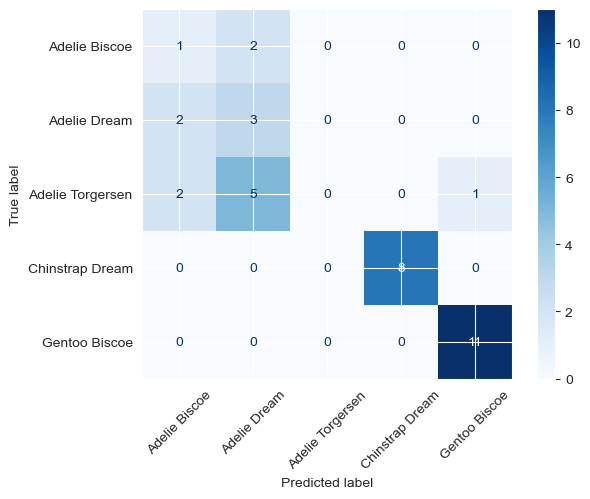

In [122]:
ConfusionMatrixDisplay.from_predictions(
    y_true=labels,
    y_pred=predictions,
    cmap='Blues',
    xticks_rotation=45,
)

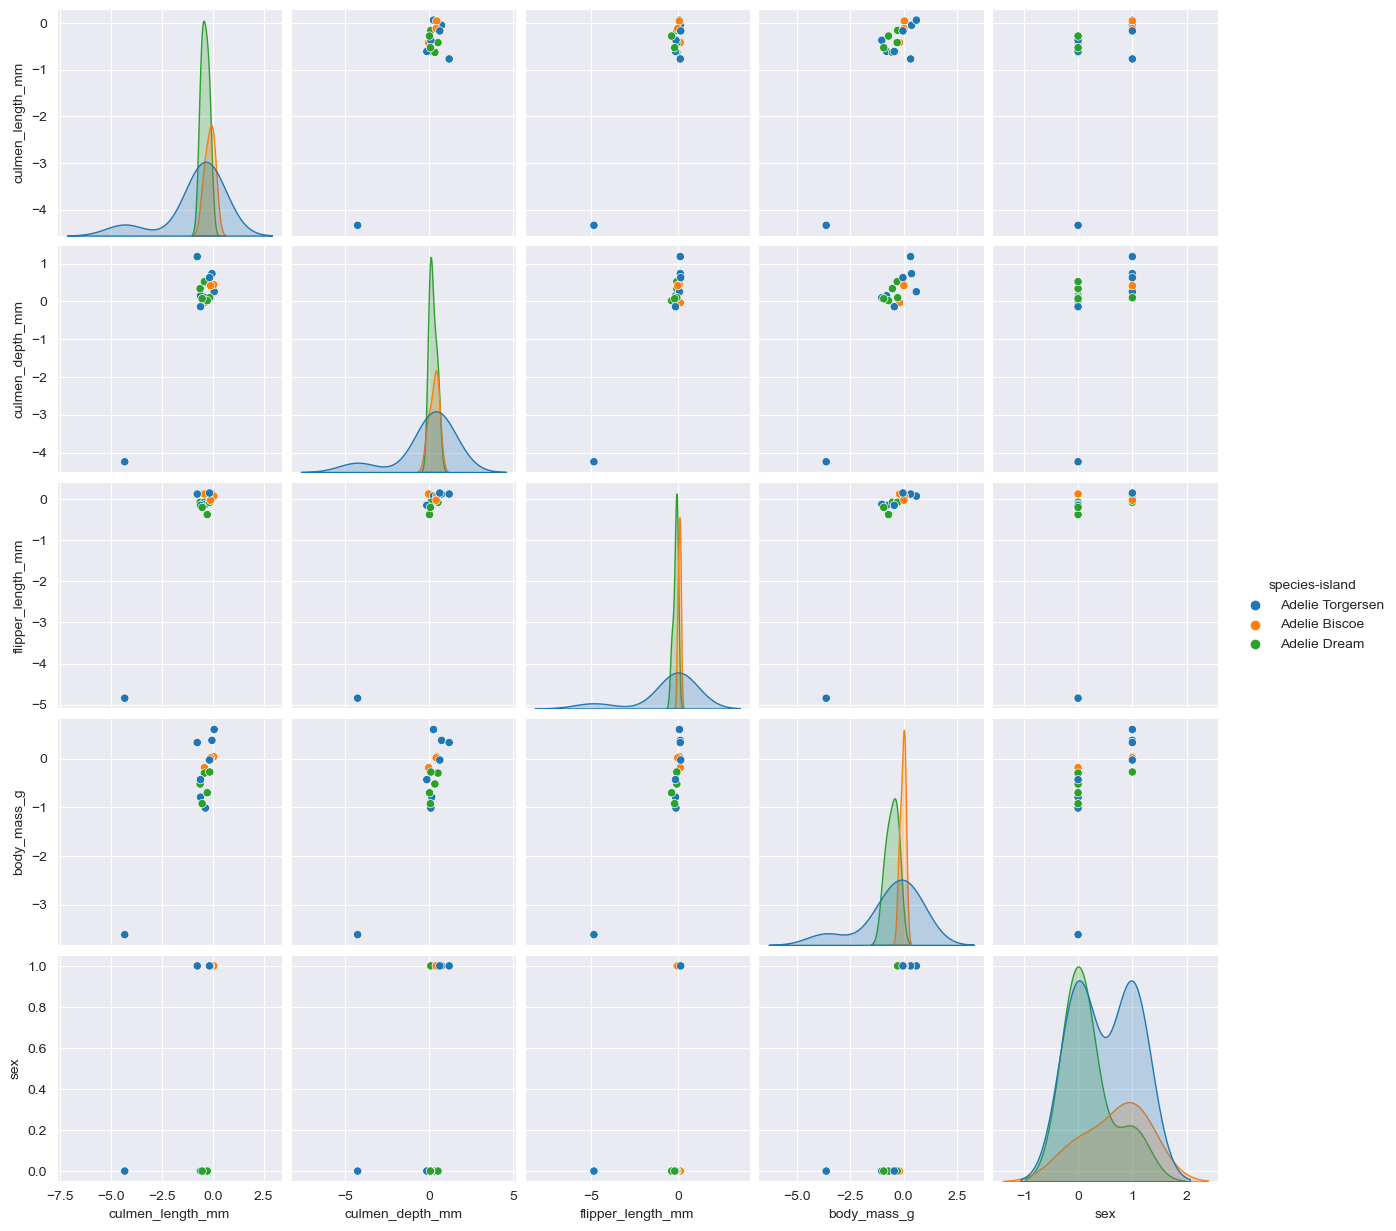

In [123]:
species_islands = test['species-island'].unique().tolist()
adelie = [si for si in species_islands if 'Adelie' in si]
sns.pairplot(test[test['species-island'].isin(adelie)], hue='species-island')

## Results:
> * #### Based on the test results of our model we can see that the model correctly classifies the penguins into their distinct species consistently, however, attempts to additionally classify the penguins based also on their respective islands has proven to be very difficult as the penguins do not differ enough from island to island for our model to accurately determine any given penguin's origin.

> * #### This model revised on the basis of species exclusively is likely to perform extremely well.